In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
df = pd.read_spss('nilt23w1.sav')

In [69]:
df['RELIGCAT'].value_counts()

RELIGCAT
Protestant     457
Catholic       398
No religion    300
Name: count, dtype: int64

In [70]:
df['PROTCATH'].value_counts()

PROTCATH
Part of the Protestant community    470
Part of the Catholic community      375
Neither                             342
Name: count, dtype: int64

In [71]:
df['URBRUR'].value_counts()

URBRUR
Urban    784
Rural    416
Name: count, dtype: int64

In [72]:
safe_area_order = ['Very safe', 'Fairly safe', 'Neither safe nor unsafe', "I don't know", 'Fairly unsafe', 'Very unsafe']

# Convert 'SAFEAREA' column to a categorical type with the specified order
df['SAFEAREA'] = pd.Categorical(df['SAFEAREA'], categories=safe_area_order, ordered=True)


In [73]:
df['AREALAWJ'].unique()

['Strongly agree', 'Agree', 'Neither agree nor disagree', 'I don't know', 'Disagree', NaN, 'Strongly disagree']
Categories (6, object): ['Agree', 'Disagree', 'I don't know', 'Neither agree nor disagree', 'Strongly agree', 'Strongly disagree']

In [74]:
agree_order = ['Strongly agree', 'Agree', 'Neither agree nor disagree', 'xx']

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Very safe'),
  Text(1, 0, 'Fairly safe'),
  Text(2, 0, 'Neither safe nor unsafe'),
  Text(3, 0, "I don't know"),
  Text(4, 0, 'Fairly unsafe'),
  Text(5, 0, 'Very unsafe')])

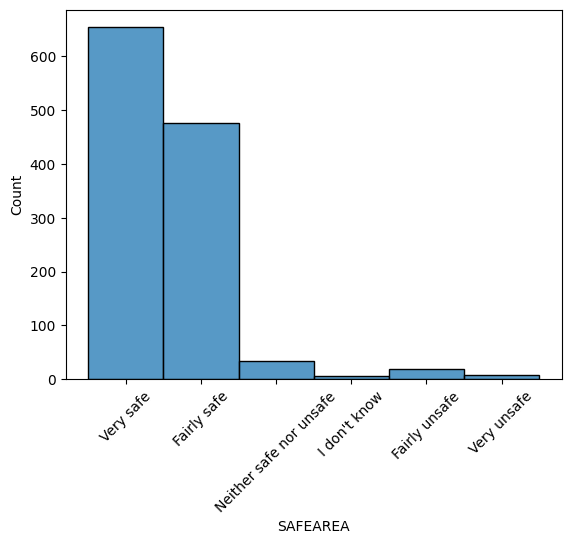

In [75]:
sns.histplot(df, x='SAFEAREA')
plt.xticks(rotation=45)

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/3763018581.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  safe_area = df.groupby(['RELAREA', 'SAFEAREA']).size().unstack()


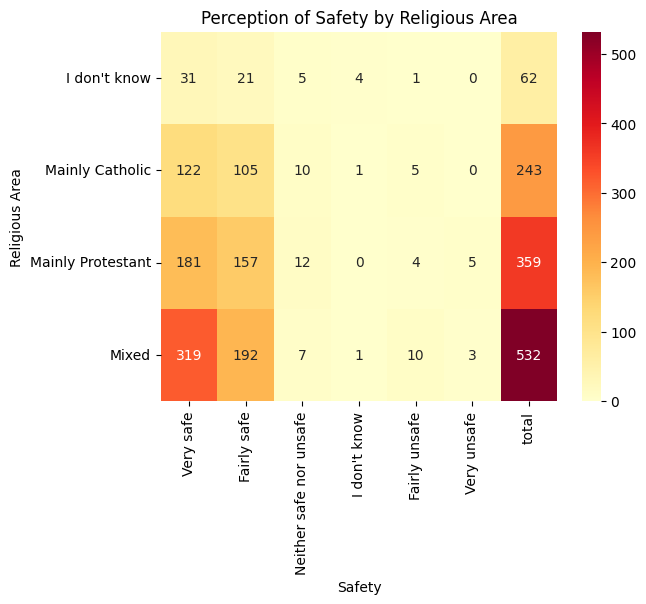

In [76]:
safe_area = df.groupby(['RELAREA', 'SAFEAREA']).size().unstack()
safe_area['total'] = safe_area.sum(axis=1)
sns.heatmap(safe_area, annot=True, fmt='d', cmap='YlOrRd', xticklabels=safe_area.columns)
plt.title('Perception of Safety by Religious Area')
plt.xlabel('Safety')
plt.ylabel('Religious Area')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/3265533426.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  safe_area_two = df.groupby(['COMMAREA', 'SAFEAREA']).size().unstack()


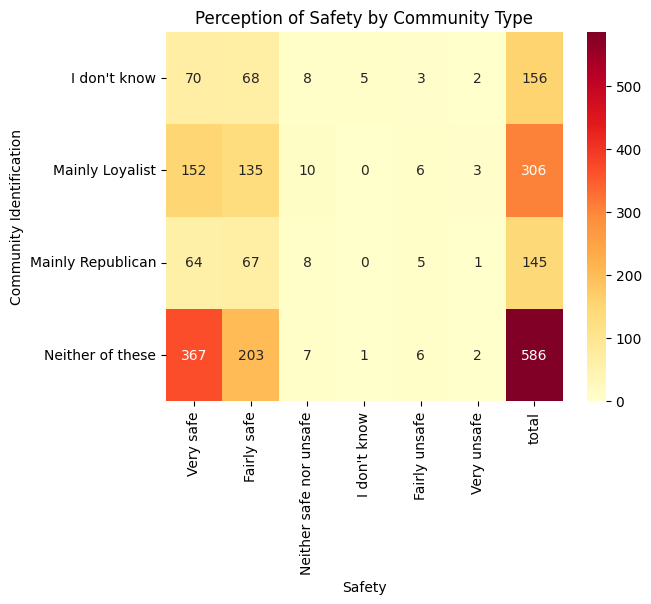

In [77]:
safe_area_two = df.groupby(['COMMAREA', 'SAFEAREA']).size().unstack()
safe_area_two['total'] = safe_area_two.sum(axis=1)
sns.heatmap(safe_area_two, annot=True, fmt='d', cmap='YlOrRd', xticklabels=safe_area_two.columns)
plt.title('Perception of Safety by Community Type')
plt.xlabel('Safety')
plt.ylabel('Community Identification')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/3522122295.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  law_justice = df.groupby(['RELAREA', 'AREALAWJ']).size().unstack()


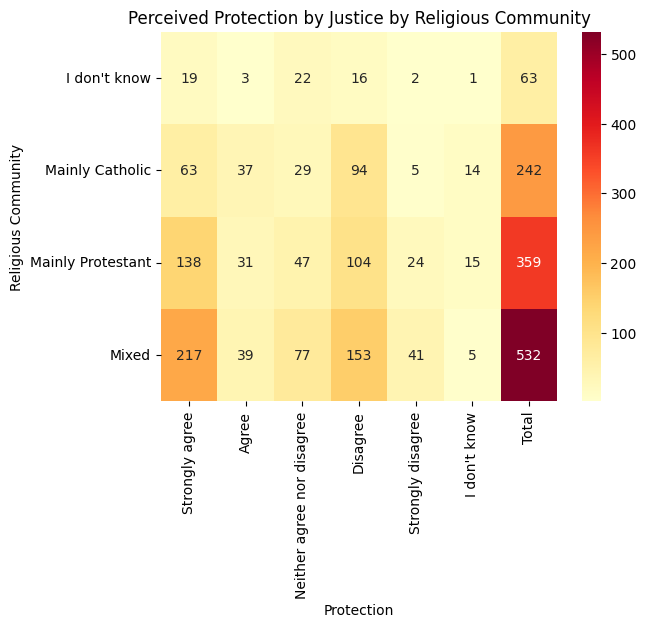

In [78]:
law_justice = df.groupby(['RELAREA', 'AREALAWJ']).size().unstack()
law_justice['total'] = law_justice.sum(axis=1)
labels = ['Strongly agree', 'Agree', 'Neither agree nor disagree', 'Disagree', 'Strongly disagree', "I don't know", 'Total']
sns.heatmap(law_justice, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perceived Protection by Justice by Religious Community')
plt.xlabel('Protection')
plt.ylabel('Religious Community')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/4247834536.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  paramilitary_perception = df.groupby(['RELAREA', 'PGCONTRL']).size().unstack()


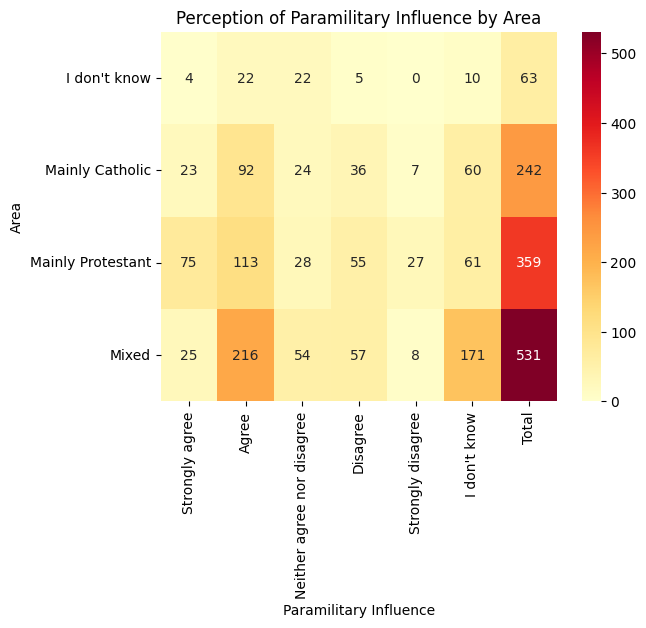

In [79]:
paramilitary_perception = df.groupby(['RELAREA', 'PGCONTRL']).size().unstack()
paramilitary_perception['total'] = paramilitary_perception.sum(axis=1)
sns.heatmap(paramilitary_perception, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perception of Paramilitary Influence by Area')
plt.xlabel('Paramilitary Influence')
plt.ylabel('Area')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/462157848.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crime = df.groupby(['RELAREA', 'YPCRIME']).size().unstack()


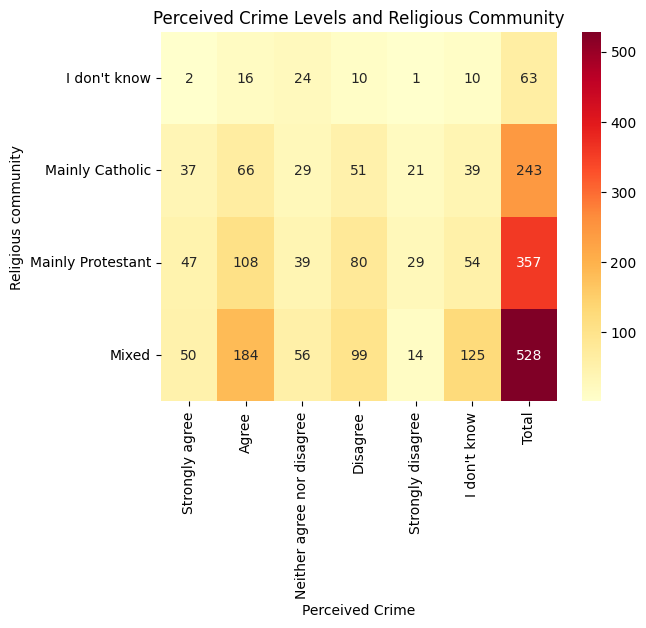

In [80]:
crime = df.groupby(['RELAREA', 'YPCRIME']).size().unstack()
crime['total'] = crime.sum(axis=1)
sns.heatmap(crime, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perceived Crime Levels and Religious Community')
plt.xlabel('Perceived Crime')
plt.ylabel('Religious community')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/2548986188.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  victims = df.groupby(['RELIGCAT', 'VICTCJS']).size().unstack()


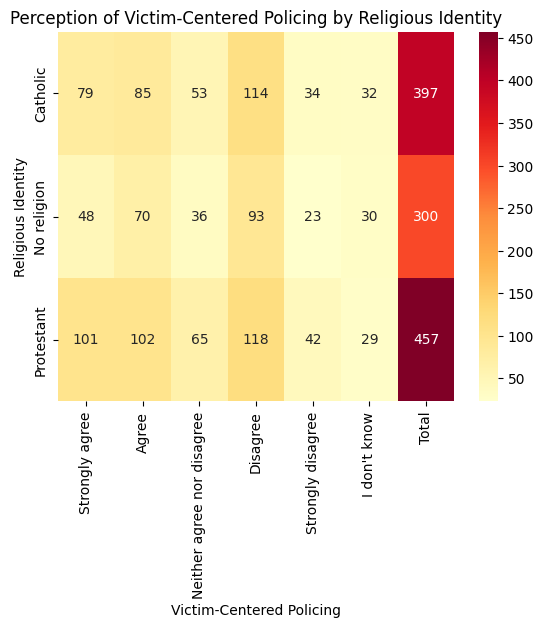

In [81]:
victims = df.groupby(['RELIGCAT', 'VICTCJS']).size().unstack()
victims['total'] = victims.sum(axis=1)
sns.heatmap(victims, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perception of Victim-Centered Policing by Religious Identity')
plt.xlabel('Victim-Centered Policing')
plt.ylabel('Religious Identity')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/2233746734.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fair = df.groupby(['RELIGCAT', 'PPSFAIR']).size().unstack()


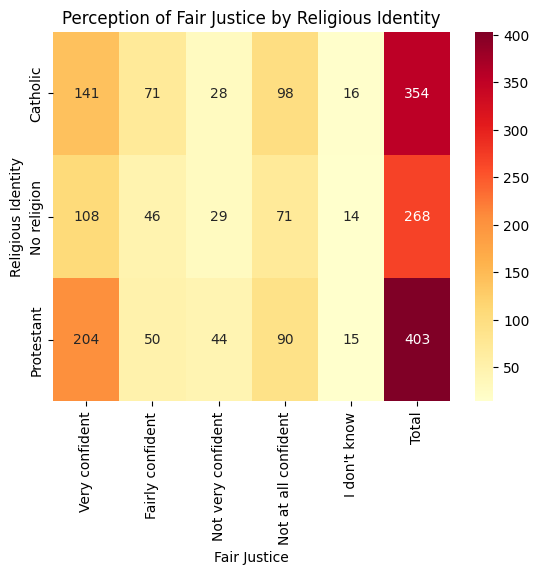

In [92]:
fair = df.groupby(['RELIGCAT', 'PPSFAIR']).size().unstack()
fair['Total'] = fair.sum(axis=1)
labels = ['Very confident', 'Fairly confident', 'Not very confident', 'Not at all confident', "I don't know", 'Total']
sns.heatmap(fair, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perception of Fair Justice by Religious Identity')
plt.xlabel('Fair Justice')
plt.ylabel('Religious Identity')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/2556331095.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ind = df.groupby(['RELIGCAT', 'PPSINDP']).size().unstack()


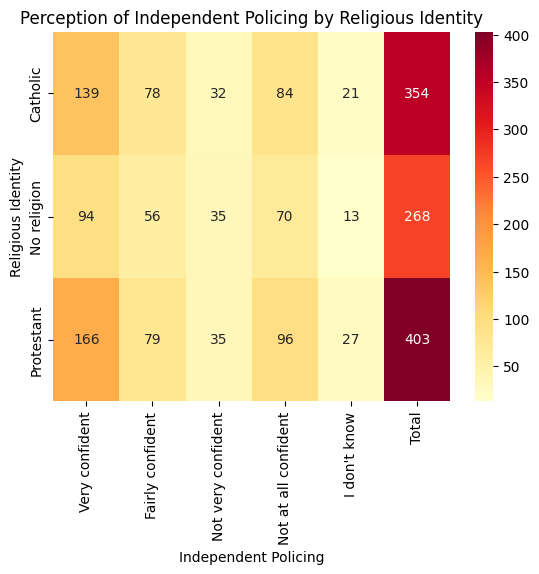

In [94]:
ind = df.groupby(['RELIGCAT', 'PPSINDP']).size().unstack()
ind['total'] = ind.sum(axis=1)
sns.heatmap(ind, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perception of Independent Policing by Religious Identity')
plt.xlabel('Independent Policing')
plt.ylabel('Religious Identity')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/841010574.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  poimpart = df.groupby(['RELIGCAT', 'POIMPART']).size().unstack()


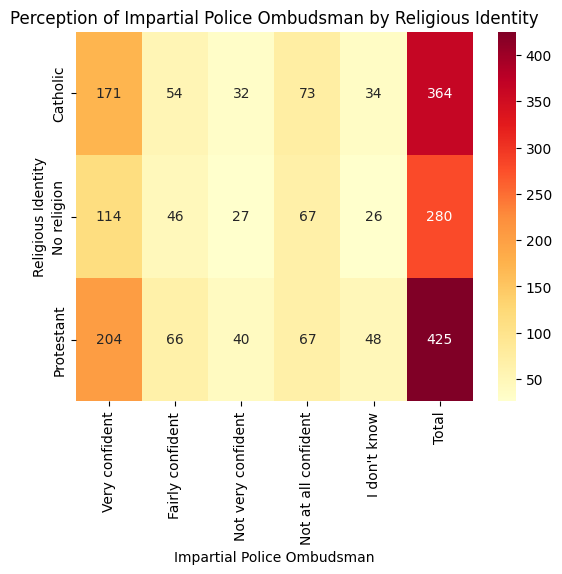

In [ ]:
poimpart = df.groupby(['RELIGCAT', 'POIMPART']).size().unstack()
poimpart['total'] = poimpart.sum(axis=1)
sns.heatmap(poimpart, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perception of Impartial Police Ombudsman by Religious Identity')
plt.xlabel('Impartial Police Ombudsman')
plt.ylabel('Religious Identity')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/132201629.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pofair = df.groupby(['RELIGCAT', 'POFAIR']).size().unstack()


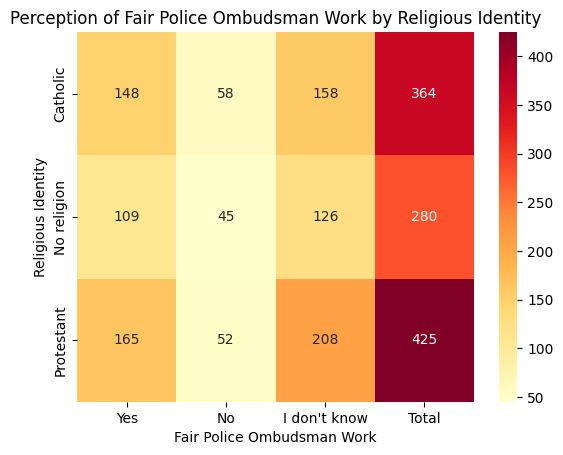

In [99]:
pofair = df.groupby(['RELIGCAT', 'POFAIR']).size().unstack()
pofair['total'] = pofair.sum(axis=1)
sns.heatmap(pofair, annot=True, fmt='d', cmap='YlOrRd', xticklabels=['Yes', 'No', "I don't know", 'Total'])
plt.title('Perception of Fair Police Ombudsman Work by Religious Identity')
plt.xlabel('Fair Police Ombudsman Work')
plt.ylabel('Religious Identity')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/2247016809.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pogoodjob = df.groupby(['RELIGCAT', 'POGOODJB']).size().unstack()


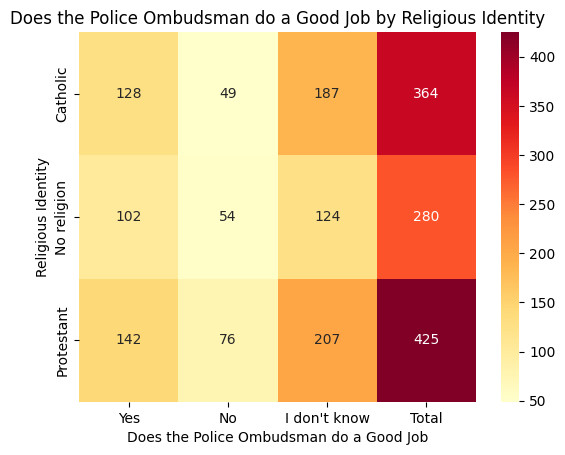

In [102]:
pogoodjob = df.groupby(['RELIGCAT', 'POGOODJB']).size().unstack()
pogoodjob['total'] = pogoodjob.sum(axis=1)
sns.heatmap(pogoodjob, annot=True, fmt='d', cmap='YlOrRd', xticklabels=['Yes', 'No', "I don't know", 'Total'])
plt.title('Does the Police Ombudsman do a Good Job by Religious Identity')
plt.xlabel('Does the Police Ombudsman do a Good Job')
plt.ylabel('Religious Identity')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/3910394652.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  confident = df.groupby(['RELAREA', 'AREAREPC']).size().unstack()


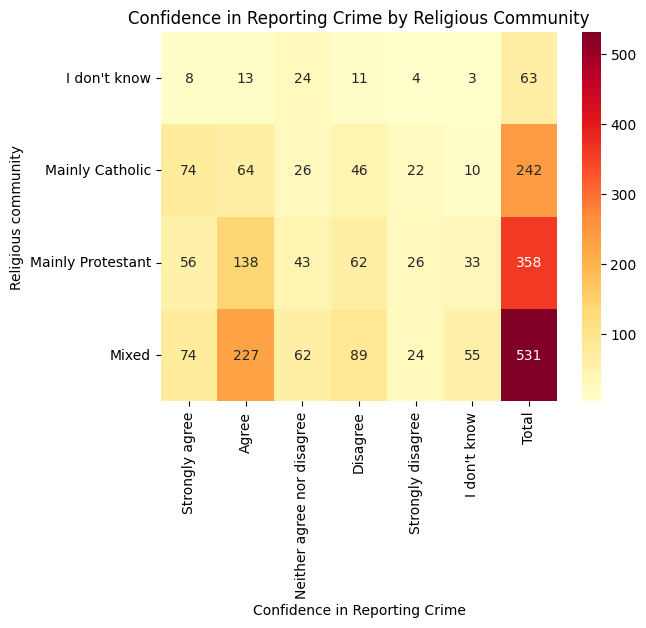

In [104]:
confident = df.groupby(['RELAREA', 'AREAREPC']).size().unstack()
confident['total'] = confident.sum(axis=1)
labels = ['Strongly agree', 'Agree', 'Neither agree nor disagree', 'Disagree', 'Strongly disagree', "I don't know", 'Total']
sns.heatmap(confident, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Confidence in Reporting Crime by Religious Community')
plt.xlabel('Confidence in Reporting Crime')
plt.ylabel('Religious community')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_5413/2343064000.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crime_reporting = df.groupby(['RELIGCAT', 'REPBURG']).size().unstack()


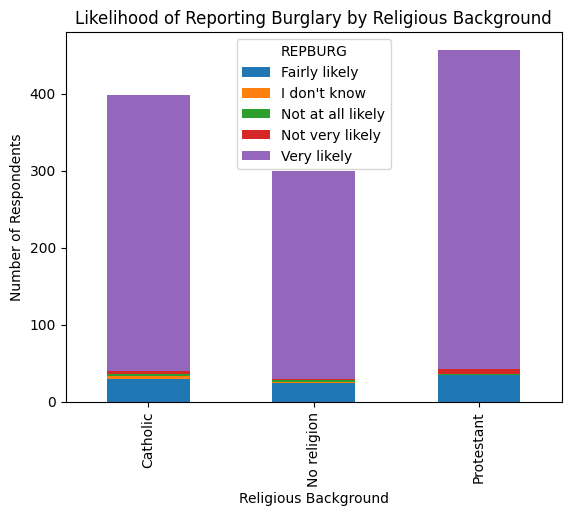

In [9]:
crime_reporting = df.groupby(['RELIGCAT', 'REPBURG']).size().unstack()
crime_reporting.plot(kind='bar', stacked=True)
plt.title('Likelihood of Reporting Burglary by Religious Background')
plt.xlabel('Religious Background')
plt.ylabel('Number of Respondents')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_5413/573184782.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pps_confidence = df.groupby(['RELIGCAT', 'PPSEFF']).size().unstack()


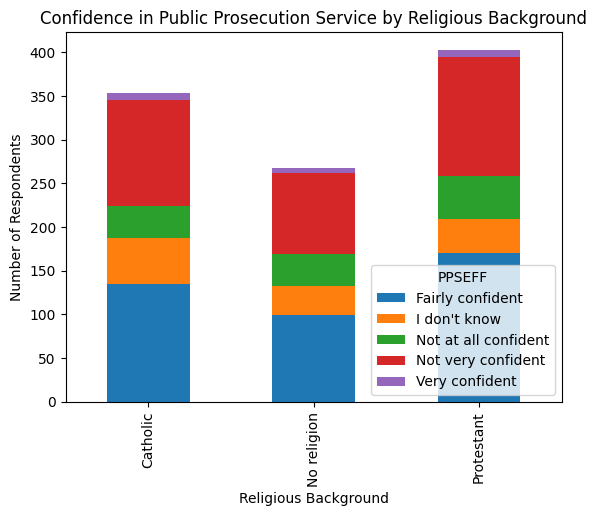

In [10]:
pps_confidence = df.groupby(['RELIGCAT', 'PPSEFF']).size().unstack()
pps_confidence.plot(kind='bar', stacked=True)
plt.title('Confidence in Public Prosecution Service by Religious Background')
plt.xlabel('Religious Background')
plt.ylabel('Number of Respondents')
plt.show()

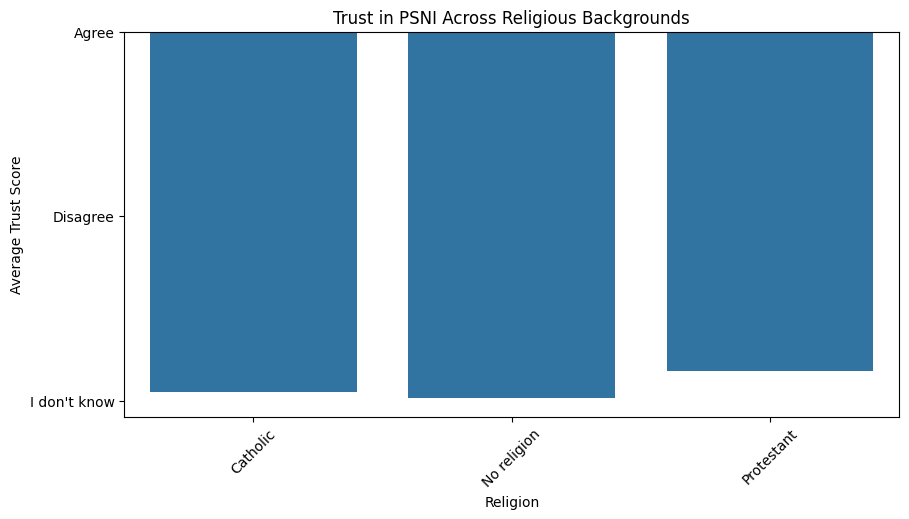

In [16]:
plt.figure(figsize=(10, 5))
sns.barplot(x="RELIGCAT", y="PSNISAFE", data=df, estimator=lambda x: sum(x) / len(x), errorbar=None)
plt.xticks(rotation=45)
plt.title("Trust in PSNI Across Religious Backgrounds")
plt.ylabel("Average Trust Score")
plt.xlabel("Religion")
plt.show()